<a href="https://colab.research.google.com/github/Ayesha-Imr/Graph-RAG-Automation-ApertureDB-Gemini/blob/main/Notebooks/GraphRAG_with_ApertureDB_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphRAG with ApertureDB: Part 1 - Building the Semantic Layer

This notebook covers the first major phase of building our GraphRAG system: augmenting the existing knowledge graph with a semantic layer. This involves creating vector embeddings for our entities and ingesting them into ApertureDB, linking them directly to the graph structure.

**Prerequisites:** This notebook is a successor to the [**Automating Knowledge Graph Creation with Gemini & ApertureDB**](https://colab.research.google.com/drive/1HoaDwiVsj9QWnSQq2GKMhNrRf0NHp2sw?usp=drive_link) notebook and assumes you have already created and ingested your plaintext graph in an ApertureDB instance. If not, please check out that notebook and run it with your preferred data source so you have a knowledge graph to work with. *(Worry not, everything is automated, all you have to do is create your [ApertureDB](https://www.aperturedata.io/) instance, add the required API keys, upload your chosen pdf aka knowledgebase and run all the cells - easy peasy!)*

## 1. Setup and Initialization

First, we'll install the required Python packages and configure our environment. This includes [Gemini embeddings](https://ai.google.dev/gemini-api/docs/embeddings) for embeddings, [ApertureDB](https://www.aperturedata.io/) and some utility packages. We then import all necessary modules and establish a connection to our ApertureDB instance using the credentials stored in Colab's secrets manager.

In [2]:
!pip install -q aperturedb google-genai

In [31]:
# Core imports
import os
import json
import time
from typing import Dict, List, Any
from tqdm import tqdm
import numpy as np

# Data models and utilities
from google.colab import userdata, files
from aperturedb.CommonLibrary import create_connector
from aperturedb.ParallelLoader import ParallelLoader
from IPython.display import HTML, display
from pprint import pprint
from google import genai
from google.genai import types, errors


Set up the API keys. You can get a Google API key [here](https://aistudio.google.com/apikey).

In [5]:
db_host = userdata.get("APERTUREDB_HOST")
db_key = userdata.get("APERTUREDB_KEY")
google_api_key = userdata.get("GOOGLE_API_KEY")

Connect to the ApertureDB client.

In [17]:
client = client = create_connector(
          key=db_key
        )

## 2. Preparing Entity Data for Embedding

Our knowledge graph contains structured entities with various properties. To make these entities searchable via semantic search, we need to represent them as vector embeddings. The first step is to convert each structured entity into a single, cohesive text "document".

The `fetch_entities` function retrieves all entity nodes from our ApertureDB graph. It does so using the [GetSchema](https://docs.aperturedata.io/query_language/Reference/db_commands/GetSchema) method provided by ApertureDB and then extracting all the classes. Then one by one, all the entities with all their properties are extracted from each class.

In [18]:
def fetch_entities(client):
    """
    Fetches all entities by first getting the schema to identify all classes,
    and then querying for entities within each class.
    """
    # Get schema and filter for valid, non-internal class names.
    schema_query = [{"GetSchema": {}}]
    schema_response, _ = client.query(schema_query)

    if not schema_response or "entities" not in schema_response[0]["GetSchema"]:
        print("Error: Could not retrieve schema from ApertureDB.")
        return []

    all_class_names = schema_response[0]["GetSchema"]["entities"]["classes"].keys()
    # Filter out internal classes (like _Blob) which cause query errors.
    valid_class_names = [name for name in all_class_names if not name.startswith('_')]
    print(f"Found valid classes in schema: {valid_class_names}")

    # Iterate and fetch entities for each valid class.
    all_entities = []
    for class_name in valid_class_names:
        entity_query = [{
            "FindEntity": {
                "with_class": class_name,
                "results": {"all_properties": True}
            }
        }]
        entity_response, _ = client.query(entity_query)

        # Ensure response is not empty and has the expected structure.
        if entity_response and entity_response[0].get("FindEntity", {}).get("entities"):
            entities_for_class = entity_response[0]["FindEntity"]["entities"]
            for entity in entities_for_class:
                entity['class'] = class_name
            all_entities.extend(entities_for_class)

    print(f"Successfully fetched a total of {len(all_entities)} entities.")
    return all_entities

The `create_entity_documents` synthesizes a document for each entity by concatenating its key properties (like name, class, definition, etc.) into a single string. This process creates a text representation that is rich in context and ideal for generating a high-quality embedding.

In [19]:
def create_entity_documents(entities):
    """
    Creates a synthesized document for each entity
    """
    entity_documents = []
    for entity in entities:
        doc_parts = [f"Entity: {entity.get('name', '')}.", f"Class: {entity.get('class', 'N/A')}."]
        other_properties = {
            k: v for k, v in entity.items()
            if k not in ["_uniqueid", "name", "class"] and v is not None
        }
        for key, value in other_properties.items():
            doc_parts.append(f"{key}: {value}.")

        entity_documents.append({
            "entity_id": entity.get("id"),
            "class": entity.get("class"),
            "document": " ".join(doc_parts)
        })

    print(f"Created {len(entity_documents)} documents for embedding.")
    return entity_documents

Calling the above functions to create documents for embedding.

In [20]:
all_entities = fetch_entities(client)
if all_entities:
    documents_to_embed = create_entity_documents(all_entities)

Found valid classes in schema: ['Application Architecture', 'Cloud Compute Resource', 'Cloud Database Service', 'Cloud Deployment Model', 'Cloud Ecosystem Role', 'Cloud Management Tool', 'Cloud Network Component', 'Cloud Service Model', 'Cloud Service Provider', 'Cloud Storage Resource', 'Computing Environment', 'Computing System', 'Container', 'Hypervisor', 'Middleware', 'Open-Source Cloud Platform', 'OpenStack Node', 'OpenStack Service', 'Orchestration Platform', 'Virtualization Technology']
Successfully fetched a total of 276 entities.
Created 276 documents for embedding.


Lets check out the first two samples to see what our documents look like. Note that the `entity_id` and `class` fields will serve as our metadata. These fields are necessary to connect embeddings to their source entities, and also to later on find neighbouring nodes (the core of graph RAG).
The `document` field contains the tex which will be converted into vector embeddings. Note how it also contains the class name and entity name along with all other entity properties. This aids vector search.

In [21]:
print("\n--- Sample Documents for Embedding ---")
for doc in documents_to_embed[:2]:
    print(json.dumps(doc, indent=2))


--- Sample Documents for Embedding ---
{
  "entity_id": 208,
  "class": "Application Architecture",
  "document": "Entity: Cloud-Native Applications (CNA). Class: Application Architecture. characteristic: Highly Scalable, Flexible, Fault-Tolerant, Lightweight & Efficient, Supports Continuous Deployment. definition: Applications designed specifically for cloud environments.. deployment_approach: Built using containers and microservices.. fault_tolerance: Fault-Tolerant. id: 208. scalability: Highly Scalable. type: Cloud-Native Applications (CNA)."
}
{
  "entity_id": 209,
  "class": "Application Architecture",
  "document": "Entity: Microservices Architecture. Class: Application Architecture. characteristic: Modular Approach: Applications are split into small, independent services.. deployment_approach: leverage cloud elasticity.. id: 209. type: Microservices Architecture."
}


## 3. Generating Vector Embeddings with Cohere

With our entity documents prepared, we can now generate the vector embeddings. We'll use [Google AI's `gemini-embedding-001`](https://ai.google.dev/gemini-api/docs/embeddings) model, which is highly performant for retrieval tasks and allows us to specify different embedding dimensions. We are using 768 as the mebdding dimensions for a balance of speed, size and accuracy. You can set a higher or lower embedding dimensions if you want.

In [23]:
GEMINI_MODEL_NAME = "gemini-embedding-001"
EMBEDDING_DIMENSIONS = 768
gemini_client = genai.Client(api_key=google_api_key)

The function `generate_embeddings_with_gemini` sends the documents to the Gemini API in batches. Batching is crucial for efficiency and to avoid hitting API rate limits when processing a large number of entities. Since Google's free tier allows 100 RPM, we add a delay to 60s between batches  to avoid rate limiting. The function then appends the resulting embedding vector to each entity's data structure in a new `embedding` field.

In [43]:
def generate_embeddings_with_gemini(docs_to_embed, batch_size: int = 96, model_name: str = GEMINI_MODEL_NAME, output_dim: int = EMBEDDING_DIMENSIONS):
    """
    Generates embeddings for a list of documents with Google Gemini.

    """
    # Extract raw text
    texts_to_embed = [item["document"] for item in docs_to_embed]

    # Batch-wise embedding
    for i in tqdm(range(0, len(texts_to_embed), batch_size), desc="Embedding Batches"):
        batch_texts = texts_to_embed[i : i + batch_size]

        # Build the config
        embed_cfg = types.EmbedContentConfig(
            output_dimensionality=output_dim,
            task_type="RETRIEVAL_DOCUMENT", # optimal for corpus items
        )

        # API call
        result = gemini_client.models.embed_content(
            model=model_name,
            contents=batch_texts,
            config=embed_cfg,
        )

        batch_embeddings = [emb.values for emb in result.embeddings]

        # Safety check
        if len(batch_embeddings) == len(batch_texts):
            for j, embedding in enumerate(batch_embeddings):
                docs_to_embed[i + j]["embedding"] = embedding
        else:
            print(
                f"Warning: API returned {len(batch_embeddings)} embeddings "
                f"for a batch of {len(batch_texts)} texts.  Skipping those rows."
            )

        # Add 1 minute delay to avoid rate limiting.
        time.sleep(60)


    # Keep only the documents that now contain an embedding
    docs_with_embeddings = [d for d in docs_to_embed if "embedding" in d]
    print(f"\nSuccessfully generated embeddings for {len(docs_with_embeddings)} documents.")
    return docs_with_embeddings

Call the function on our curated documents.

In [44]:
docs_with_embeddings = generate_embeddings_with_gemini(documents_to_embed)

Embedding Batches: 100%|██████████| 3/3 [03:02<00:00, 60.85s/it]


Successfully generated embeddings for 276 documents.


Lets print out and check a sample of the resultant docs_with_embeddings data structure.

In [45]:
first_doc = docs_with_embeddings[0]
print(f"Document for Entity ID: {first_doc['entity_id']}")
print(f"Embedding generated: {'embedding' in first_doc}")
print(f"Embedding dimensions: {len(first_doc['embedding'])}")
print(f"Sample of embedding vector: {np.array(first_doc['embedding'][:5])}")

Document for Entity ID: 208
Embedding generated: True
Embedding dimensions: 768
Sample of embedding vector: [-0.00747136  0.01111416 -0.00263643 -0.0615893  -0.00403898]


## 4. Creating the Vector Index in ApertureDB

Before we can store our embeddings, we need a place for them to live. In ApertureDB, vector indexes are called [**`DescriptorSets`**](https://docs.aperturedata.io/HowToGuides/start/Embeddings).

In [46]:
DESCRIPTOR_SET_NAME = "entity_embeddings_gemini"

The `create_vector_index` function defines and creates a new `DescriptorSet` named `entity_embeddings_gemini`. We configure it with the correct dimensionality (768 for our Gemini embedding model), a distance metric (Cosine Similarity - `CS`), and a search engine (`HNSW`, a popular choice for fast and accurate nearest-neighbor search). The function is idempotent, meaning it will safely skip creation if the set already exists.

In [47]:
def create_vector_index(client, set_name, dimensions):
    """
    Creates a new DescriptorSet to serve as a vector index if it doesn't exist.
    """
    print(f"Checking for DescriptorSet: '{set_name}'...")

    # Check if the DescriptorSet already exists.
    find_query = [{
        "FindDescriptorSet": {
            "_ref": 1,
            "with_name": DESCRIPTOR_SET_NAME,
            "metrics": True,
            "engines": True,
        }
    }]
    response, _ = client.query(find_query)

    if response and response[0].get("FindDescriptorSet", {}).get("returned") == 1:
        print(f"DescriptorSet '{set_name}' already exists. Skipping creation.")
        return

    # If not found, create it.
    print(f"Creating DescriptorSet '{set_name}'...")
    create_query = [{
        "AddDescriptorSet": {
            "name": set_name,
            "dimensions": dimensions,
            "metric": "CS",
            "engine": "HNSW"
        }
    }]
    response, _ = client.query(create_query)

    if response[0]["AddDescriptorSet"]["status"] == 0:
        print(f"Successfully created DescriptorSet '{set_name}'.")
    else:
        print(f"Error creating DescriptorSet: {response[0]['AddDescriptorSet']['info']}")

In [48]:
create_vector_index(client, DESCRIPTOR_SET_NAME, EMBEDDING_DIMENSIONS)

Checking for DescriptorSet: 'entity_embeddings_gemini'...
Creating DescriptorSet 'entity_embeddings_gemini'...
Successfully created DescriptorSet 'entity_embeddings_gemini'.


## 5. Ingesting Embeddings and Linking to the Graph

Now we'll ingest all the generated embeddings into our `DescriptorSet` and, most importantly, connect each embedding back to its original entity in the knowledge graph. This link is what enables our hybrid GraphRAG approach.

We perform this in two efficient, parallelized stages using ApertureDB's [`ParallelLoader`](https://docs.aperturedata.io/python_sdk/parallel_exec/ParallelLoader).

The `ingest_embeddings` function first adds all the vector embeddings as [`Descriptor`](https://docs.aperturedata.io/HowToGuides/start/Embeddings) objects (embeddings in ApertureDB) into our `entity_embeddings_gemini` set. We also store the original entity's ID and class as properties/metadata on the descriptor itself for easy lookup later - as alluded to earlier.

In [49]:
def ingest_embeddings(client, set_name, docs_with_embeddings):

    """ Ingests the descriptors and their embeddings in parallel. """

    data_to_ingest = []

    for doc in docs_with_embeddings:
        query = [{
            "AddDescriptor": {
                "set": set_name,
                "properties": {
                    # We store the entity's ID and class on the descriptor itself, so we can find it easily in the next step
                    "source_entity_id": doc.get("entity_id"),
                    "source_entity_class": doc.get("class")
                }
            }
        }]

        # Convert the embedding to bytes.
        blobs = [np.array(doc["embedding"], dtype=np.float32).tobytes()]
        data_to_ingest.append((query, blobs))

    loader = ParallelLoader(client)
    loader.ingest(generator=data_to_ingest, batchsize=64, numthreads=8, stats=True)

Lets ingest our embeddings aka Descriptors into the DescriptorSet.

In [50]:
ingest_embeddings(client, DESCRIPTOR_SET_NAME, docs_with_embeddings)

Progress: 100%|██████████| 276/276 [00:02<00:00, 137items/s]

============ ApertureDB Loader Stats ============
Total time (s): 2.02325439453125
Total queries executed: 8
Avg Query time (s): 0.8534371852874756
Query time std: 0.25802589034100953
Avg Query Throughput (q/s): 9.373859187194011
Overall insertion throughput (element/s): 136.41388880509217
Total inserted elements: 276
Total successful commands: 276


As you can see from the ApertureDB Web UI, there are 276 Descriptors present in our instance - one for each entity.

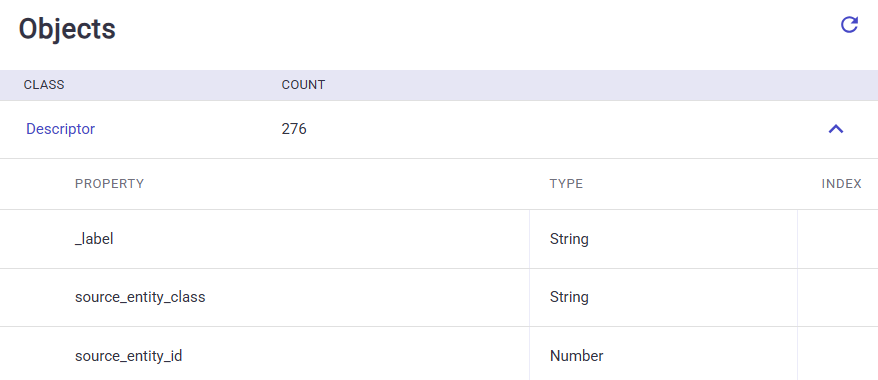

After the descriptors are ingested, `create_connections` function creates the `has_embedding` connections. For each entity, it finds the node in the graph and its corresponding descriptor (using the properties we just stored) and creates an edge between them. This is needed to trace back retrieved embeddings from vector search to the original source entities and find neighbouring nodes.

In [51]:
def create_connections(client, set_name, docs_with_embeddings):

    """ Creates the 'has_embedding' connections in parallel """

    queries_to_run = []

    for doc in docs_with_embeddings:
        entity_id = doc.get("entity_id")
        entity_class = doc.get("class")

        # Find the entity, find its corresponding descriptor, and create the connection between them.
        query = [
            {
                "FindEntity": {
                    "with_class": entity_class,
                    "constraints": {"id": ["==", entity_id]},
                    "_ref": 1
                }
            },
            {
                "FindDescriptor": {
                    "set": set_name,
                    # Find the descriptor using the properties we stored in Step 1.
                    "constraints": {"source_entity_id": ["==", entity_id]},
                    "_ref": 2
                }
            },
            {
                "AddConnection": {
                    "class": "has_embedding",
                    "src": 1,
                    "dst": 2
                }
            }
        ]
        queries_to_run.append((query, []))

    loader = ParallelLoader(client)
    loader.ingest(generator=queries_to_run, batchsize=64, numthreads=8, stats=True)

Lets create the connections between Descriptors/embeddings and the source entities in our knowledge graph.

In [52]:
create_connections(client, DESCRIPTOR_SET_NAME, docs_with_embeddings)

Progress: 100%|██████████| 276/276 [00:02<00:00, 136items/s]

============ ApertureDB Loader Stats ============
Total time (s): 2.029325485229492
Total queries executed: 8
Avg Query time (s): 0.7648613452911377
Query time std: 0.2689092551366647
Avg Query Throughput (q/s): 10.45941208723899
Overall insertion throughput (element/s): 136.00578222117372
Total inserted elements: 276
Total successful commands: 828


We can confirm the number of connections by running the following query:

In [53]:
# Confirm the connections
query = [{
    "FindConnection": {
        "with_class": "has_embedding",
        "results": {
            "count": True
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "FindConnection": {
            "count": 276,
            "returned": 0,
            "status": 0
        }
    }
]


As expected, the count matches the number of entities we processed.

And that's it! Our embeddings have now been ingested and linked to the source entities. Now we can move on and actually perform RAG and see the powerful capabilities of graph RAG in action! Covered in [Part 2](https://colab.research.google.com/drive/1l0PvOjq0vswWpzC4l-l8y0BZbX8ZT30I?usp=sharing).